In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from helpers import normalize_token, filter_token
import pymc
import numpy as np
import scipy

In [3]:
text_root = '../../data/EmbryoProjectTexts/files'
zotero_export_path = '../../data/EmbryoProjectTexts'

documents = nltk.corpus.PlaintextCorpusReader(text_root, 'https.+')
metadata = zotero.read(zotero_export_path, index_by='link', follow_links=False)

In [4]:
before_2012_freqs = nltk.ConditionalFreqDist([(fileid, normalize_token(token))
               for fileid in documents.fileids() 
                for token in documents.words(fileids=[fileid])
               if metadata[fileid].date < 2012 and filter_token(token)])

In [5]:
before_2012_tokens = [normalize_token(token) for fileid in documents.fileids()
                      for token in documents.words(fileids=[fileid])
                      if metadata[fileid].date < 2012 and filter_token(token)]

In [6]:
before = [nltk.FreqDist(before_2012_tokens[i:i+1000])['organizer'] 
          for i in xrange(0, len(before_2012_tokens), 1000)]

In [7]:
after_2012_tokens = [normalize_token(token) for fileid in documents.fileids()
                      for token in documents.words(fileids=[fileid])
                      if metadata[fileid].date >= 2012 and filter_token(token)]

In [8]:
after = [nltk.FreqDist(after_2012_tokens[i:i+1000])['organizer'] 
          for i in xrange(0, len(after_2012_tokens), 1000)]

In [9]:
def make_model(before, after):
    before_mean = pymc.Exponential('before_mean', beta=1.)
    after_mean = pymc.Exponential('after_mean', beta=1.)
    before_poisson = pymc.Poisson('before', mu=before_mean, value=before, observed=True)
    after_poisson = pymc.Poisson('after', mu=after_mean, value=after, observed=True)
    return locals()

In [10]:
M = pymc.MCMC(make_model(before, after))

In [11]:
M.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sec

Plotting after_mean
Plotting before_mean


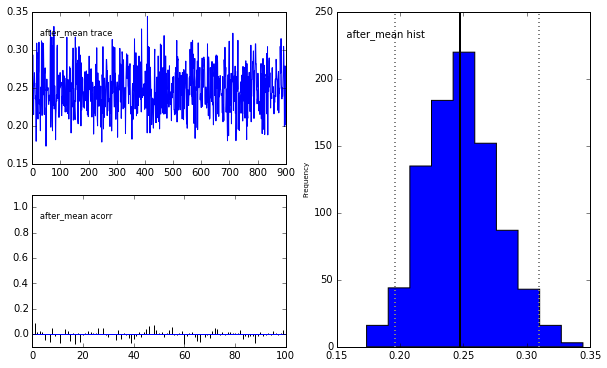

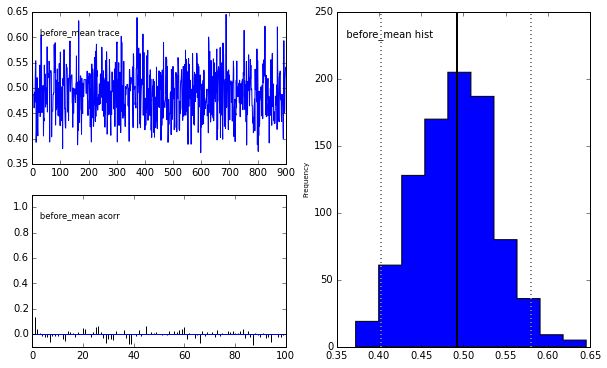

In [13]:
pymc.Matplot.plot(M)

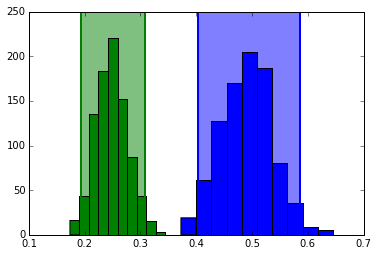

In [12]:
plt.hist(M.trace('before_mean')[:])
before_lower, before_upper = scipy.stats.mstats.mquantiles(M.trace('before_mean')[:], [0.025, 0.975])
plt.plot([before_lower, before_lower], [0, 250], color='blue', lw=2)
plt.plot([before_upper, before_upper], [0, 250], color='blue', lw=2)
plt.fill_betweenx(arange(0, 250), before_lower, before_upper, alpha=0.5)

plt.hist(M.trace('after_mean')[:])
after_lower, after_upper = scipy.stats.mstats.mquantiles(M.trace('after_mean')[:], [0.025, 0.975])

plt.plot([after_lower, after_lower], [0, 250], color='green', lw=2)
plt.plot([after_upper, after_upper], [0, 250], color='green', lw=2)
plt.fill_betweenx(arange(0, 250), after_lower, after_upper, alpha=0.5, color='green')


plt.show()